In this notebook, we'll experiment to see how adding more patrons to a market can change the long term outcome of the market. As usual, here are a few utility functions.

In [1]:
WEI = 1
GWEI = 10**9
WHOLE = 10**18

def wei_to_whole(amount):
    return amount // 10**18

def gwei_to_whole(amount):
    return amount // 10**9

def gwei_to_wei(amount):
    return amount * 10**9

def wei_to_gwei(amount):
    return amount // 10**9

def convert_support_price(price):
    """Support price is ETH wei / MKT gwei. Convert to ETH whole / MKT whole"""
    if price >= 10**9:
        # ETH gwei / MKT gwei
        price_gwei_to_gwei = wei_to_gwei(price)
        # Note units cancel
        price_whole_to_whole = price_gwei_to_gwei
        return price_whole_to_whole
    else:
        # price is less than 1 gwei ETH to purchase 1 gwei MKT
        num_gwei_purchased = WHOLE // price
        num_mkt_purchased = num_gwei_purchased // 10**9
        return 1.0 / num_mkt_purchased

Here are the market parameters. The rest of the notebook is designed so that if you change these parameters, the rest of the notebook should execute correctly

In [2]:
PRICE_FLOOR = int(.001 * GWEI)
SPREAD = 110 # 10 %
LIST_REWARD = .000025 * WHOLE # MKT
STAKE = .01 * WHOLE # MKT
VOTE_BY = 7 # Days. Are units right?
BACKEND_PAYMENT = 5
MAKER_PAYMENT = 25
RESERVE_PAYMENT = 100 - BACKEND_PAYMENT - MAKER_PAYMENT
COST_PER_BYTE = 100 * GWEI # ETH

Ok, now let's define the parameters that govern the current simulation. 

In [3]:
CREATOR_SUPPORT = 0 * WHOLE # ETH

Let's now define the number of patrons that the market can possibly attract.

In [4]:
NUMBER_PATRONS = 200
SUPPORT = 100 * WHOLE # ETH

One of the core assumptions of this simulation is that makers are rational and are drawn into the market with larger reserve. For now, we model this as a very simple curve that assumes that the addition of 10 ETH is enough to motivate a new maker to enter the market.

In [5]:
# This is the maximum number makers on the network
MAX_MAKERS = 1000
# This is number of listings *per* maker
N_LISTINGS_PER_MAKER = 100
def get_number_makers(reserve_size):
    return min(reserve_size // 10, MAX_MAKERS)

A second core assumption is that buyers are drawn to markets with more listings. For now, we model this as a very simple curve that assumes that the addition of 1000 listings is enough to motivate a new buyer to enter the market.

In [6]:
# This is the maximum number buyers on the network
MAX_BUYERS = 100
# Size of an individual data purchase in ETH
PURCHASE_SIZE = 1000 * WHOLE # ETH
def get_number_buyers(n_listings):
    return min(n_listings // 1000, MAX_BUYERS)

We have one large cell that models the entire simple market simulation.

In [7]:

def run_simulation(N_PATRONS):
  print("-------------------------------------------------------------")
  print("Running simulation with %d patrons" % N_PATRONS)
  RESERVE = 0 # Initial reserve is empty
  MARKET_TOTAL = 0 # No Market tokens at start

  # Creator does their thing
  CREATOR_BLOCK_SIZE = 1 * WHOLE # MKT
  MARKET_TOTAL += CREATOR_BLOCK_SIZE
  # Creator deposits funds in reserve
  RESERVE += CREATOR_SUPPORT
  print("MARKET_TOTAL: %d, RESERVE: %d" % (wei_to_whole(MARKET_TOTAL), wei_to_whole(RESERVE)))

  # Data Structure to keep track of coin table
  coin_table = {}
  # We're just going to use whole units for convenience
  coin_table["CREATOR"] = CREATOR_BLOCK_SIZE / 10**18

  # Now some patrons join the market.
  print("SUPPORT: %d" % wei_to_whole(SUPPORT))
  for i in range(N_PATRONS):
      print("Patron %d supports" % (i+1))
      if MARKET_TOTAL < 1 * WHOLE:
          SUPPORT_PRICE = PRICE_FLOOR + ((SPREAD * RESERVE * GWEI) // (100 * 1 * WHOLE))
      else:
          SUPPORT_PRICE = PRICE_FLOOR + ((SPREAD * RESERVE * GWEI) // (100 * MARKET_TOTAL))
      print("SUPPORT_PRICE (ETH whole for MKT whole): %f" % convert_support_price(SUPPORT_PRICE))
      MINTED = (SUPPORT // SUPPORT_PRICE) * GWEI # Units of WEI
      print("MINTED: %f" % (MINTED / 10**18))
      MARKET_TOTAL += MINTED
      RESERVE += SUPPORT
      coin_table["PATRON_%d" % (i+1)] = MINTED / 10**18

  # Now let's add some makers
  N_MAKERS = get_number_makers(RESERVE // 10**18)
  print("%d makers have entered a market with reserve %d"% (N_MAKERS, RESERVE // 10**18))
  for i in range(N_MAKERS):
      for j in range(N_LISTINGS_PER_MAKER):
          MAKER = "MAKER_%d" % (i+1)
          MINTED = LIST_REWARD
          MARKET_TOTAL += MINTED
          if MAKER not in coin_table:
              coin_table[MAKER] = 0
          coin_table[MAKER] += MINTED/10**18
  N_LISTINGS = N_MAKERS * N_LISTINGS_PER_MAKER
  print("%d listings total added" % N_LISTINGS)

  # Now let's add some purchases
  BACKEND_REVENUE = 0
  N_BUYERS = get_number_buyers(N_LISTINGS)
  print("%d buyers total entering the market" % N_BUYERS)
  for n in range(N_BUYERS):
      #print("Purchase %d" % n)
      PURCHASE = PURCHASE_SIZE
      BACKEND_SHARE = (PURCHASE * BACKEND_PAYMENT)//100
      MAKER_SHARE = (PURCHASE * MAKER_PAYMENT)//100
      RESERVE_SHARE = (PURCHASE * RESERVE_PAYMENT)//100
      # Pay out the reserve share
      RESERVE += RESERVE_SHARE
      # Backend share is paid directly to backend
      BACKEND_REVENUE += BACKEND_SHARE
      # The maker share is created via the support() function. Let's find the current support price:
      SUPPORT_PRICE = PRICE_FLOOR + ((SPREAD * RESERVE * GWEI) // (100 * MARKET_TOTAL))
      #print("SUPPORT_PRICE (ETH whole for MKT whole): %d" % convert_support_price(SUPPORT_PRICE))
      # Now mint the makers their access rewards
      ONE_MAKER_SHARE = MAKER_SHARE // N_MAKERS
      MINTED = (ONE_MAKER_SHARE // SUPPORT_PRICE) * GWEI # Units of WEI
    
  print("#####################")
  print("MARKET_TOTAL: %f" % (MARKET_TOTAL / 10**18))
  print("RESERVE: %f" % (RESERVE / 10**18))
  CREATOR_ETH = (coin_table["CREATOR"]/(MARKET_TOTAL / 10**18)) * (RESERVE / 10**18)
  print("CREATOR ETH: %f" % CREATOR_ETH)
  CREATOR_PROFIT = CREATOR_ETH - (CREATOR_SUPPORT / 10**18)
  print("CREATOR PROFIT: %f" % CREATOR_PROFIT)
  # All patrons have the same share
  PATRON_ETH = (coin_table["PATRON_1"]/(MARKET_TOTAL / 10**18)) * (RESERVE / 10**18)
  print("BACKEND_REVENUE: %f" % (BACKEND_REVENUE / 10**18))
  print("PATRON ETH: %f" % PATRON_ETH)
  PATRON_PROFIT = PATRON_ETH - (SUPPORT/10**18)
  print("PATRON_PROFIT: %f" % PATRON_PROFIT)
  MAKER_ETH = (coin_table["MAKER_1"]/(MARKET_TOTAL / 10**18)) * (RESERVE / 10**18)
  print("MAKER ETH: %f" % MAKER_ETH)
  print("Ending simulation")
  print("-------------------------------------------------------------")
  return N_MAKERS, N_BUYERS, (RESERVE / 10**18)

patrons_list = [n_patrons + 1 for n_patrons in range(NUMBER_PATRONS)]
reserve_sizes = []
makers_list = []
buyers_list = []
for n_patrons in patrons_list:
    n_makers, n_buyers, reserve_size = run_simulation(N_PATRONS=n_patrons)
    makers_list.append(n_makers)
    buyers_list.append(n_buyers)
    reserve_sizes.append(reserve_size)  

-------------------------------------------------------------
Running simulation with 1 patrons
MARKET_TOTAL: 1, RESERVE: 0
SUPPORT: 100
Patron 1 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.001000
MINTED: 100000.000000
10 makers have entered a market with reserve 100
1000 listings total added
1 buyers total entering the market
#####################
MARKET_TOTAL: 100001.025000
RESERVE: 800.000000
CREATOR ETH: 0.008000
CREATOR PROFIT: 0.008000
BACKEND_REVENUE: 50.000000
PATRON ETH: 799.991800
PATRON_PROFIT: 699.991800
MAKER ETH: 0.000020
Ending simulation
-------------------------------------------------------------
-------------------------------------------------------------
Running simulation with 2 patrons
MARKET_TOTAL: 1, RESERVE: 0
SUPPORT: 100
Patron 1 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.001000
MINTED: 100000.000000
Patron 2 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002101
MINTED: 47619.297053
20 makers have entered a market with reserve 200
2000 

MINTED: 22913.355209
Patron 22 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.004425
MINTED: 22660.860954
Patron 23 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.004464
MINTED: 22423.606137
Patron 24 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.004505
MINTED: 22200.032057
Patron 25 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.004566
MINTED: 21988.794071
Patron 26 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.004608
MINTED: 21788.747202
Patron 27 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.004651
MINTED: 21598.873921
Patron 28 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.004673
MINTED: 21418.293707
280 makers have entered a market with reserve 2800
28000 listings total added
28 buyers total entering the market
#####################
MARKET_TOTAL: 830924.602924
RESERVE: 22400.000000
CREATOR ETH: 0.026958
CREATOR PROFIT: 0.026958
BACKEND_REVENUE: 1400.000000
PATRON ETH: 2695.792124
PATRON_PROFIT: 2595.792124
MAKER ETH: 0.000067
Ending simulatio

38000 listings total added
38 buyers total entering the market
#####################
MARKET_TOTAL: 1036761.334548
RESERVE: 30400.000000
CREATOR ETH: 0.029322
CREATOR PROFIT: 0.029322
BACKEND_REVENUE: 1900.000000
PATRON ETH: 2932.208116
PATRON_PROFIT: 2832.208116
MAKER ETH: 0.000073
Ending simulation
-------------------------------------------------------------
-------------------------------------------------------------
Running simulation with 39 patrons
MARKET_TOTAL: 1, RESERVE: 0
SUPPORT: 100
Patron 1 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.001000
MINTED: 100000.000000
Patron 2 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002101
MINTED: 47619.297053
Patron 3 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002494
MINTED: 40155.659398
Patron 4 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002762
MINTED: 36265.876748
Patron 5 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002967
MINTED: 33739.125037
Patron 6 supports
SUPPORT_PRICE (ETH whole for MKT wh

47000 listings total added
47 buyers total entering the market
#####################
MARKET_TOTAL: 1211908.328719
RESERVE: 37600.000000
CREATOR ETH: 0.031025
CREATOR PROFIT: 0.031025
BACKEND_REVENUE: 2350.000000
PATRON ETH: 3102.544896
PATRON_PROFIT: 3002.544896
MAKER ETH: 0.000078
Ending simulation
-------------------------------------------------------------
-------------------------------------------------------------
Running simulation with 48 patrons
MARKET_TOTAL: 1, RESERVE: 0
SUPPORT: 100
Patron 1 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.001000
MINTED: 100000.000000
Patron 2 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002101
MINTED: 47619.297053
Patron 3 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002494
MINTED: 40155.659398
Patron 4 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002762
MINTED: 36265.876748
Patron 5 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002967
MINTED: 33739.125037
Patron 6 supports
SUPPORT_PRICE (ETH whole for MKT wh

55000 listings total added
55 buyers total entering the market
#####################
MARKET_TOTAL: 1361578.078840
RESERVE: 44000.000000
CREATOR ETH: 0.032315
CREATOR PROFIT: 0.032315
BACKEND_REVENUE: 2750.000000
PATRON ETH: 3231.544388
PATRON_PROFIT: 3131.544388
MAKER ETH: 0.000081
Ending simulation
-------------------------------------------------------------
-------------------------------------------------------------
Running simulation with 56 patrons
MARKET_TOTAL: 1, RESERVE: 0
SUPPORT: 100
Patron 1 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.001000
MINTED: 100000.000000
Patron 2 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002101
MINTED: 47619.297053
Patron 3 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002494
MINTED: 40155.659398
Patron 4 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002762
MINTED: 36265.876748
Patron 5 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002967
MINTED: 33739.125037
Patron 6 supports
SUPPORT_PRICE (ETH whole for MKT wh

62000 listings total added
62 buyers total entering the market
#####################
MARKET_TOTAL: 1488776.317702
RESERVE: 49600.000000
CREATOR ETH: 0.033316
CREATOR PROFIT: 0.033316
BACKEND_REVENUE: 3100.000000
PATRON ETH: 3331.595177
PATRON_PROFIT: 3231.595177
MAKER ETH: 0.000083
Ending simulation
-------------------------------------------------------------
-------------------------------------------------------------
Running simulation with 63 patrons
MARKET_TOTAL: 1, RESERVE: 0
SUPPORT: 100
Patron 1 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.001000
MINTED: 100000.000000
Patron 2 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002101
MINTED: 47619.297053
Patron 3 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002494
MINTED: 40155.659398
Patron 4 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002762
MINTED: 36265.876748
Patron 5 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002967
MINTED: 33739.125037
Patron 6 supports
SUPPORT_PRICE (ETH whole for MKT wh

68000 listings total added
68 buyers total entering the market
#####################
MARKET_TOTAL: 1595419.105550
RESERVE: 54400.000000
CREATOR ETH: 0.034098
CREATOR PROFIT: 0.034098
BACKEND_REVENUE: 3400.000000
PATRON ETH: 3409.762351
PATRON_PROFIT: 3309.762351
MAKER ETH: 0.000085
Ending simulation
-------------------------------------------------------------
-------------------------------------------------------------
Running simulation with 69 patrons
MARKET_TOTAL: 1, RESERVE: 0
SUPPORT: 100
Patron 1 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.001000
MINTED: 100000.000000
Patron 2 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002101
MINTED: 47619.297053
Patron 3 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002494
MINTED: 40155.659398
Patron 4 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002762
MINTED: 36265.876748
Patron 5 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002967
MINTED: 33739.125037
Patron 6 supports
SUPPORT_PRICE (ETH whole for MKT wh

74000 listings total added
74 buyers total entering the market
#####################
MARKET_TOTAL: 1700125.347769
RESERVE: 59200.000000
CREATOR ETH: 0.034821
CREATOR PROFIT: 0.034821
BACKEND_REVENUE: 3700.000000
PATRON ETH: 3482.096192
PATRON_PROFIT: 3382.096192
MAKER ETH: 0.000087
Ending simulation
-------------------------------------------------------------
-------------------------------------------------------------
Running simulation with 75 patrons
MARKET_TOTAL: 1, RESERVE: 0
SUPPORT: 100
Patron 1 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.001000
MINTED: 100000.000000
Patron 2 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002101
MINTED: 47619.297053
Patron 3 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002494
MINTED: 40155.659398
Patron 4 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002762
MINTED: 36265.876748
Patron 5 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002967
MINTED: 33739.125037
Patron 6 supports
SUPPORT_PRICE (ETH whole for MKT wh

SUPPORT_PRICE (ETH whole for MKT whole): 0.004032
MINTED: 24878.666742
Patron 16 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.004098
MINTED: 24481.518167
Patron 17 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.004149
MINTED: 24117.556689
Patron 18 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.004219
MINTED: 23782.185621
Patron 19 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.004274
MINTED: 23471.660435
Patron 20 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.004329
MINTED: 23182.906409
Patron 21 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.004367
MINTED: 22913.355209
Patron 22 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.004425
MINTED: 22660.860954
Patron 23 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.004464
MINTED: 22423.606137
Patron 24 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.004505
MINTED: 22200.032057
Patron 25 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.004566
MINTED: 21988.794071
Patron 26 supports
SUPPORT_PR

PATRON ETH: 3591.922913
PATRON_PROFIT: 3491.922913
MAKER ETH: 0.000090
Ending simulation
-------------------------------------------------------------
-------------------------------------------------------------
Running simulation with 85 patrons
MARKET_TOTAL: 1, RESERVE: 0
SUPPORT: 100
Patron 1 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.001000
MINTED: 100000.000000
Patron 2 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002101
MINTED: 47619.297053
Patron 3 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002494
MINTED: 40155.659398
Patron 4 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002762
MINTED: 36265.876748
Patron 5 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002967
MINTED: 33739.125037
Patron 6 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.003135
MINTED: 31912.238790
Patron 7 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.003279
MINTED: 30503.875212
Patron 8 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.003413
MINTED: 29370.56816

89000 listings total added
89 buyers total entering the market
#####################
MARKET_TOTAL: 1954658.837687
RESERVE: 71200.000000
CREATOR ETH: 0.036426
CREATOR PROFIT: 0.036426
BACKEND_REVENUE: 4450.000000
PATRON ETH: 3642.579392
PATRON_PROFIT: 3542.579392
MAKER ETH: 0.000091
Ending simulation
-------------------------------------------------------------
-------------------------------------------------------------
Running simulation with 90 patrons
MARKET_TOTAL: 1, RESERVE: 0
SUPPORT: 100
Patron 1 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.001000
MINTED: 100000.000000
Patron 2 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002101
MINTED: 47619.297053
Patron 3 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002494
MINTED: 40155.659398
Patron 4 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002762
MINTED: 36265.876748
Patron 5 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002967
MINTED: 33739.125037
Patron 6 supports
SUPPORT_PRICE (ETH whole for MKT wh

94000 listings total added
94 buyers total entering the market
#####################
MARKET_TOTAL: 2037505.391023
RESERVE: 75200.000000
CREATOR ETH: 0.036908
CREATOR PROFIT: 0.036908
BACKEND_REVENUE: 4700.000000
PATRON ETH: 3690.787781
PATRON_PROFIT: 3590.787781
MAKER ETH: 0.000092
Ending simulation
-------------------------------------------------------------
-------------------------------------------------------------
Running simulation with 95 patrons
MARKET_TOTAL: 1, RESERVE: 0
SUPPORT: 100
Patron 1 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.001000
MINTED: 100000.000000
Patron 2 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002101
MINTED: 47619.297053
Patron 3 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002494
MINTED: 40155.659398
Patron 4 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002762
MINTED: 36265.876748
Patron 5 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002967
MINTED: 33739.125037
Patron 6 supports
SUPPORT_PRICE (ETH whole for MKT wh

MINTED: 33739.125037
Patron 6 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.003135
MINTED: 31912.238790
Patron 7 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.003279
MINTED: 30503.875212
Patron 8 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.003413
MINTED: 29370.568165
Patron 9 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.003521
MINTED: 28430.130821
Patron 10 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.003623
MINTED: 27631.461514
Patron 11 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.003717
MINTED: 26940.845447
Patron 12 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.003802
MINTED: 26334.958551
Patron 13 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.003891
MINTED: 25797.051500
Patron 14 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.003953
MINTED: 25314.757364
Patron 15 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.004032
MINTED: 24878.666742
Patron 16 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.004098
MINTED: 24481.

PATRON_PROFIT: 3598.841836
MAKER ETH: 0.000092
Ending simulation
-------------------------------------------------------------
-------------------------------------------------------------
Running simulation with 103 patrons
MARKET_TOTAL: 1, RESERVE: 0
SUPPORT: 100
Patron 1 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.001000
MINTED: 100000.000000
Patron 2 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002101
MINTED: 47619.297053
Patron 3 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002494
MINTED: 40155.659398
Patron 4 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002762
MINTED: 36265.876748
Patron 5 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002967
MINTED: 33739.125037
Patron 6 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.003135
MINTED: 31912.238790
Patron 7 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.003279
MINTED: 30503.875212
Patron 8 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.003413
MINTED: 29370.568165
Patron 9 supports
SUP

Patron 8 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.003413
MINTED: 29370.568165
Patron 9 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.003521
MINTED: 28430.130821
Patron 10 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.003623
MINTED: 27631.461514
Patron 11 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.003717
MINTED: 26940.845447
Patron 12 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.003802
MINTED: 26334.958551
Patron 13 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.003891
MINTED: 25797.051500
Patron 14 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.003953
MINTED: 25314.757364
Patron 15 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.004032
MINTED: 24878.666742
Patron 16 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.004098
MINTED: 24481.518167
Patron 17 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.004149
MINTED: 24117.556689
Patron 18 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.004219
MINTED: 23782.185621
Patron 19 su

-------------------------------------------------------------
-------------------------------------------------------------
Running simulation with 111 patrons
MARKET_TOTAL: 1, RESERVE: 0
SUPPORT: 100
Patron 1 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.001000
MINTED: 100000.000000
Patron 2 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002101
MINTED: 47619.297053
Patron 3 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002494
MINTED: 40155.659398
Patron 4 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002762
MINTED: 36265.876748
Patron 5 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002967
MINTED: 33739.125037
Patron 6 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.003135
MINTED: 31912.238790
Patron 7 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.003279
MINTED: 30503.875212
Patron 8 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.003413
MINTED: 29370.568165
Patron 9 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.003521
MINTED: 28430.1308

100000 listings total added
100 buyers total entering the market
#####################
MARKET_TOTAL: 2360597.364562
RESERVE: 81400.000000
CREATOR ETH: 0.034483
CREATOR PROFIT: 0.034483
BACKEND_REVENUE: 5000.000000
PATRON ETH: 3448.279712
PATRON_PROFIT: 3348.279712
MAKER ETH: 0.000086
Ending simulation
-------------------------------------------------------------
-------------------------------------------------------------
Running simulation with 115 patrons
MARKET_TOTAL: 1, RESERVE: 0
SUPPORT: 100
Patron 1 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.001000
MINTED: 100000.000000
Patron 2 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002101
MINTED: 47619.297053
Patron 3 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002494
MINTED: 40155.659398
Patron 4 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002762
MINTED: 36265.876748
Patron 5 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002967
MINTED: 33739.125037
Patron 6 supports
SUPPORT_PRICE (ETH whole for MKT

100000 listings total added
100 buyers total entering the market
#####################
MARKET_TOTAL: 2423804.242158
RESERVE: 81800.000000
CREATOR ETH: 0.033749
CREATOR PROFIT: 0.033749
BACKEND_REVENUE: 5000.000000
PATRON ETH: 3374.860006
PATRON_PROFIT: 3274.860006
MAKER ETH: 0.000084
Ending simulation
-------------------------------------------------------------
-------------------------------------------------------------
Running simulation with 119 patrons
MARKET_TOTAL: 1, RESERVE: 0
SUPPORT: 100
Patron 1 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.001000
MINTED: 100000.000000
Patron 2 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002101
MINTED: 47619.297053
Patron 3 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002494
MINTED: 40155.659398
Patron 4 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002762
MINTED: 36265.876748
Patron 5 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002967
MINTED: 33739.125037
Patron 6 supports
SUPPORT_PRICE (ETH whole for MKT

100000 listings total added
100 buyers total entering the market
#####################
MARKET_TOTAL: 2486589.254366
RESERVE: 82200.000000
CREATOR ETH: 0.033057
CREATOR PROFIT: 0.033057
BACKEND_REVENUE: 5000.000000
PATRON ETH: 3305.732937
PATRON_PROFIT: 3205.732937
MAKER ETH: 0.000083
Ending simulation
-------------------------------------------------------------
-------------------------------------------------------------
Running simulation with 123 patrons
MARKET_TOTAL: 1, RESERVE: 0
SUPPORT: 100
Patron 1 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.001000
MINTED: 100000.000000
Patron 2 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002101
MINTED: 47619.297053
Patron 3 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002494
MINTED: 40155.659398
Patron 4 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002762
MINTED: 36265.876748
Patron 5 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002967
MINTED: 33739.125037
Patron 6 supports
SUPPORT_PRICE (ETH whole for MKT

100000 listings total added
100 buyers total entering the market
#####################
MARKET_TOTAL: 2548970.064767
RESERVE: 82600.000000
CREATOR ETH: 0.032405
CREATOR PROFIT: 0.032405
BACKEND_REVENUE: 5000.000000
PATRON ETH: 3240.524522
PATRON_PROFIT: 3140.524522
MAKER ETH: 0.000081
Ending simulation
-------------------------------------------------------------
-------------------------------------------------------------
Running simulation with 127 patrons
MARKET_TOTAL: 1, RESERVE: 0
SUPPORT: 100
Patron 1 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.001000
MINTED: 100000.000000
Patron 2 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002101
MINTED: 47619.297053
Patron 3 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002494
MINTED: 40155.659398
Patron 4 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002762
MINTED: 36265.876748
Patron 5 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002967
MINTED: 33739.125037
Patron 6 supports
SUPPORT_PRICE (ETH whole for MKT

100000 listings total added
100 buyers total entering the market
#####################
MARKET_TOTAL: 2610963.055973
RESERVE: 83000.000000
CREATOR ETH: 0.031789
CREATOR PROFIT: 0.031789
BACKEND_REVENUE: 5000.000000
PATRON ETH: 3178.903654
PATRON_PROFIT: 3078.903654
MAKER ETH: 0.000079
Ending simulation
-------------------------------------------------------------
-------------------------------------------------------------
Running simulation with 131 patrons
MARKET_TOTAL: 1, RESERVE: 0
SUPPORT: 100
Patron 1 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.001000
MINTED: 100000.000000
Patron 2 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002101
MINTED: 47619.297053
Patron 3 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002494
MINTED: 40155.659398
Patron 4 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002762
MINTED: 36265.876748
Patron 5 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002967
MINTED: 33739.125037
Patron 6 supports
SUPPORT_PRICE (ETH whole for MKT

100000 listings total added
100 buyers total entering the market
#####################
MARKET_TOTAL: 2672583.452017
RESERVE: 83400.000000
CREATOR ETH: 0.031206
CREATOR PROFIT: 0.031206
BACKEND_REVENUE: 5000.000000
PATRON ETH: 3120.576083
PATRON_PROFIT: 3020.576083
MAKER ETH: 0.000078
Ending simulation
-------------------------------------------------------------
-------------------------------------------------------------
Running simulation with 135 patrons
MARKET_TOTAL: 1, RESERVE: 0
SUPPORT: 100
Patron 1 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.001000
MINTED: 100000.000000
Patron 2 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002101
MINTED: 47619.297053
Patron 3 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002494
MINTED: 40155.659398
Patron 4 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002762
MINTED: 36265.876748
Patron 5 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002967
MINTED: 33739.125037
Patron 6 supports
SUPPORT_PRICE (ETH whole for MKT

100000 listings total added
100 buyers total entering the market
#####################
MARKET_TOTAL: 2733845.434046
RESERVE: 83800.000000
CREATOR ETH: 0.030653
CREATOR PROFIT: 0.030653
BACKEND_REVENUE: 5000.000000
PATRON ETH: 3065.279366
PATRON_PROFIT: 2965.279366
MAKER ETH: 0.000077
Ending simulation
-------------------------------------------------------------
-------------------------------------------------------------
Running simulation with 139 patrons
MARKET_TOTAL: 1, RESERVE: 0
SUPPORT: 100
Patron 1 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.001000
MINTED: 100000.000000
Patron 2 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002101
MINTED: 47619.297053
Patron 3 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002494
MINTED: 40155.659398
Patron 4 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002762
MINTED: 36265.876748
Patron 5 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002967
MINTED: 33739.125037
Patron 6 supports
SUPPORT_PRICE (ETH whole for MKT

MINTED: 17687.973186
Patron 68 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.005682
MINTED: 17633.241623
Patron 69 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.005714
MINTED: 17579.549218
Patron 70 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.005714
MINTED: 17526.867812
Patron 71 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.005747
MINTED: 17475.160806
Patron 72 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.005747
MINTED: 17424.395548
Patron 73 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.005780
MINTED: 17374.543202
Patron 74 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.005780
MINTED: 17325.575634
Patron 75 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.005814
MINTED: 17277.462397
Patron 76 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.005814
MINTED: 17230.179694
Patron 77 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.005848
MINTED: 17183.701328
Patron 78 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.005848
MINTED: 17

100000 listings total added
100 buyers total entering the market
#####################
MARKET_TOTAL: 2840230.812966
RESERVE: 84500.000000
CREATOR ETH: 0.029751
CREATOR PROFIT: 0.029751
BACKEND_REVENUE: 5000.000000
PATRON ETH: 2975.110319
PATRON_PROFIT: 2875.110319
MAKER ETH: 0.000074
Ending simulation
-------------------------------------------------------------
-------------------------------------------------------------
Running simulation with 146 patrons
MARKET_TOTAL: 1, RESERVE: 0
SUPPORT: 100
Patron 1 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.001000
MINTED: 100000.000000
Patron 2 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002101
MINTED: 47619.297053
Patron 3 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002494
MINTED: 40155.659398
Patron 4 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002762
MINTED: 36265.876748
Patron 5 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002967
MINTED: 33739.125037
Patron 6 supports
SUPPORT_PRICE (ETH whole for MKT

MINTED: 17800.720929
Patron 66 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.005650
MINTED: 17743.788565
Patron 67 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.005682
MINTED: 17687.973186
Patron 68 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.005682
MINTED: 17633.241623
Patron 69 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.005714
MINTED: 17579.549218
Patron 70 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.005714
MINTED: 17526.867812
Patron 71 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.005747
MINTED: 17475.160806
Patron 72 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.005747
MINTED: 17424.395548
Patron 73 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.005780
MINTED: 17374.543202
Patron 74 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.005780
MINTED: 17325.575634
Patron 75 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.005814
MINTED: 17277.462397
Patron 76 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.005814
MINTED: 17

100000 listings total added
100 buyers total entering the market
#####################
MARKET_TOTAL: 2945623.533803
RESERVE: 85200.000000
CREATOR ETH: 0.028924
CREATOR PROFIT: 0.028924
BACKEND_REVENUE: 5000.000000
PATRON ETH: 2892.426647
PATRON_PROFIT: 2792.426647
MAKER ETH: 0.000072
Ending simulation
-------------------------------------------------------------
-------------------------------------------------------------
Running simulation with 153 patrons
MARKET_TOTAL: 1, RESERVE: 0
SUPPORT: 100
Patron 1 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.001000
MINTED: 100000.000000
Patron 2 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002101
MINTED: 47619.297053
Patron 3 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002494
MINTED: 40155.659398
Patron 4 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002762
MINTED: 36265.876748
Patron 5 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002967
MINTED: 33739.125037
Patron 6 supports
SUPPORT_PRICE (ETH whole for MKT

100000 listings total added
100 buyers total entering the market
#####################
MARKET_TOTAL: 3005424.853484
RESERVE: 85600.000000
CREATOR ETH: 0.028482
CREATOR PROFIT: 0.028482
BACKEND_REVENUE: 5000.000000
PATRON ETH: 2848.183008
PATRON_PROFIT: 2748.183008
MAKER ETH: 0.000071
Ending simulation
-------------------------------------------------------------
-------------------------------------------------------------
Running simulation with 157 patrons
MARKET_TOTAL: 1, RESERVE: 0
SUPPORT: 100
Patron 1 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.001000
MINTED: 100000.000000
Patron 2 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002101
MINTED: 47619.297053
Patron 3 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002494
MINTED: 40155.659398
Patron 4 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002762
MINTED: 36265.876748
Patron 5 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002967
MINTED: 33739.125037
Patron 6 supports
SUPPORT_PRICE (ETH whole for MKT

100000 listings total added
100 buyers total entering the market
#####################
MARKET_TOTAL: 3064931.050244
RESERVE: 86000.000000
CREATOR ETH: 0.028059
CREATOR PROFIT: 0.028059
BACKEND_REVENUE: 5000.000000
PATRON ETH: 2805.935879
PATRON_PROFIT: 2705.935879
MAKER ETH: 0.000070
Ending simulation
-------------------------------------------------------------
-------------------------------------------------------------
Running simulation with 161 patrons
MARKET_TOTAL: 1, RESERVE: 0
SUPPORT: 100
Patron 1 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.001000
MINTED: 100000.000000
Patron 2 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002101
MINTED: 47619.297053
Patron 3 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002494
MINTED: 40155.659398
Patron 4 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002762
MINTED: 36265.876748
Patron 5 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002967
MINTED: 33739.125037
Patron 6 supports
SUPPORT_PRICE (ETH whole for MKT

Patron 135 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006536
MINTED: 15348.565147
Patron 136 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006536
MINTED: 15326.379857
Patron 137 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006536
MINTED: 15304.403827
Patron 138 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006579
MINTED: 15282.633198
Patron 139 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006579
MINTED: 15261.064157
Patron 140 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006579
MINTED: 15239.692938
Patron 141 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006579
MINTED: 15218.518136
Patron 142 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006623
MINTED: 15197.533744
Patron 143 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006623
MINTED: 15176.738431
Patron 144 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006623
MINTED: 15156.128585
Patron 145 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006623
MINTED: 15135.702929

100000 listings total added
100 buyers total entering the market
#####################
MARKET_TOTAL: 3168384.675967
RESERVE: 86700.000000
CREATOR ETH: 0.027364
CREATOR PROFIT: 0.027364
BACKEND_REVENUE: 5000.000000
PATRON ETH: 2736.410154
PATRON_PROFIT: 2636.410154
MAKER ETH: 0.000068
Ending simulation
-------------------------------------------------------------
-------------------------------------------------------------
Running simulation with 168 patrons
MARKET_TOTAL: 1, RESERVE: 0
SUPPORT: 100
Patron 1 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.001000
MINTED: 100000.000000
Patron 2 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002101
MINTED: 47619.297053
Patron 3 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002494
MINTED: 40155.659398
Patron 4 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002762
MINTED: 36265.876748
Patron 5 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002967
MINTED: 33739.125037
Patron 6 supports
SUPPORT_PRICE (ETH whole for MKT

SUPPORT_PRICE (ETH whole for MKT whole): 0.006024
MINTED: 16642.944923
Patron 91 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006024
MINTED: 16605.594059
Patron 92 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006061
MINTED: 16568.770089
Patron 93 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006061
MINTED: 16532.461654
Patron 94 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006098
MINTED: 16496.657612
Patron 95 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006098
MINTED: 16461.341609
Patron 96 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006098
MINTED: 16426.505678
Patron 97 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006135
MINTED: 16392.136626
Patron 98 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006135
MINTED: 16358.224171
Patron 99 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006135
MINTED: 16324.755545
Patron 100 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006173
MINTED: 16291.723511
Patron 101 supports
SUPPORT_

100000 listings total added
100 buyers total entering the market
#####################
MARKET_TOTAL: 3271009.474857
RESERVE: 87400.000000
CREATOR ETH: 0.026720
CREATOR PROFIT: 0.026720
BACKEND_REVENUE: 5000.000000
PATRON ETH: 2671.958020
PATRON_PROFIT: 2571.958020
MAKER ETH: 0.000067
Ending simulation
-------------------------------------------------------------
-------------------------------------------------------------
Running simulation with 175 patrons
MARKET_TOTAL: 1, RESERVE: 0
SUPPORT: 100
Patron 1 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.001000
MINTED: 100000.000000
Patron 2 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002101
MINTED: 47619.297053
Patron 3 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002494
MINTED: 40155.659398
Patron 4 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002762
MINTED: 36265.876748
Patron 5 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002967
MINTED: 33739.125037
Patron 6 supports
SUPPORT_PRICE (ETH whole for MKT

SUPPORT_PRICE (ETH whole for MKT whole): 0.006536
MINTED: 15326.379857
Patron 137 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006536
MINTED: 15304.403827
Patron 138 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006579
MINTED: 15282.633198
Patron 139 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006579
MINTED: 15261.064157
Patron 140 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006579
MINTED: 15239.692938
Patron 141 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006579
MINTED: 15218.518136
Patron 142 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006623
MINTED: 15197.533744
Patron 143 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006623
MINTED: 15176.738431
Patron 144 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006623
MINTED: 15156.128585
Patron 145 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006623
MINTED: 15135.702929
Patron 146 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006623
MINTED: 15115.455629
Patron 147 supports

100000 listings total added
100 buyers total entering the market
#####################
MARKET_TOTAL: 3372847.701847
RESERVE: 88100.000000
CREATOR ETH: 0.026120
CREATOR PROFIT: 0.026120
BACKEND_REVENUE: 5000.000000
PATRON ETH: 2612.036113
PATRON_PROFIT: 2512.036113
MAKER ETH: 0.000065
Ending simulation
-------------------------------------------------------------
-------------------------------------------------------------
Running simulation with 182 patrons
MARKET_TOTAL: 1, RESERVE: 0
SUPPORT: 100
Patron 1 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.001000
MINTED: 100000.000000
Patron 2 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002101
MINTED: 47619.297053
Patron 3 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002494
MINTED: 40155.659398
Patron 4 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002762
MINTED: 36265.876748
Patron 5 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002967
MINTED: 33739.125037
Patron 6 supports
SUPPORT_PRICE (ETH whole for MKT

100000 listings total added
100 buyers total entering the market
#####################
MARKET_TOTAL: 3430702.784867
RESERVE: 88500.000000
CREATOR ETH: 0.025796
CREATOR PROFIT: 0.025796
BACKEND_REVENUE: 5000.000000
PATRON ETH: 2579.646374
PATRON_PROFIT: 2479.646374
MAKER ETH: 0.000064
Ending simulation
-------------------------------------------------------------
-------------------------------------------------------------
Running simulation with 186 patrons
MARKET_TOTAL: 1, RESERVE: 0
SUPPORT: 100
Patron 1 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.001000
MINTED: 100000.000000
Patron 2 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002101
MINTED: 47619.297053
Patron 3 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002494
MINTED: 40155.659398
Patron 4 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002762
MINTED: 36265.876748
Patron 5 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002967
MINTED: 33739.125037
Patron 6 supports
SUPPORT_PRICE (ETH whole for MKT

SUPPORT_PRICE (ETH whole for MKT whole): 0.004032
MINTED: 24878.666742
Patron 16 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.004098
MINTED: 24481.518167
Patron 17 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.004149
MINTED: 24117.556689
Patron 18 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.004219
MINTED: 23782.185621
Patron 19 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.004274
MINTED: 23471.660435
Patron 20 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.004329
MINTED: 23182.906409
Patron 21 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.004367
MINTED: 22913.355209
Patron 22 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.004425
MINTED: 22660.860954
Patron 23 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.004464
MINTED: 22423.606137
Patron 24 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.004505
MINTED: 22200.032057
Patron 25 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.004566
MINTED: 21988.794071
Patron 26 supports
SUPPORT_PR

SUPPORT_PRICE (ETH whole for MKT whole): 0.006757
MINTED: 14813.833810
Patron 163 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006803
MINTED: 14796.257020
Patron 164 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006803
MINTED: 14778.817993
Patron 165 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006803
MINTED: 14761.515901
Patron 166 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006803
MINTED: 14744.345580
Patron 167 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006803
MINTED: 14727.308421
Patron 168 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006803
MINTED: 14710.401475
Patron 169 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006849
MINTED: 14693.621822
Patron 170 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006849
MINTED: 14676.968725
Patron 171 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006849
MINTED: 14660.439303
Patron 172 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006849
MINTED: 14644.032849
Patron 173 supports

100000 listings total added
100 buyers total entering the market
#####################
MARKET_TOTAL: 3574315.275271
RESERVE: 89500.000000
CREATOR ETH: 0.025040
CREATOR PROFIT: 0.025040
BACKEND_REVENUE: 5000.000000
PATRON ETH: 2503.976094
PATRON_PROFIT: 2403.976094
MAKER ETH: 0.000063
Ending simulation
-------------------------------------------------------------
-------------------------------------------------------------
Running simulation with 196 patrons
MARKET_TOTAL: 1, RESERVE: 0
SUPPORT: 100
Patron 1 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.001000
MINTED: 100000.000000
Patron 2 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002101
MINTED: 47619.297053
Patron 3 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002494
MINTED: 40155.659398
Patron 4 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002762
MINTED: 36265.876748
Patron 5 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.002967
MINTED: 33739.125037
Patron 6 supports
SUPPORT_PRICE (ETH whole for MKT

SUPPORT_PRICE (ETH whole for MKT whole): 0.005988
MINTED: 16719.290634
Patron 89 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006024
MINTED: 16680.839820
Patron 90 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006024
MINTED: 16642.944923
Patron 91 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006024
MINTED: 16605.594059
Patron 92 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006061
MINTED: 16568.770089
Patron 93 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006061
MINTED: 16532.461654
Patron 94 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006098
MINTED: 16496.657612
Patron 95 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006098
MINTED: 16461.341609
Patron 96 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006098
MINTED: 16426.505678
Patron 97 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006135
MINTED: 16392.136626
Patron 98 supports
SUPPORT_PRICE (ETH whole for MKT whole): 0.006135
MINTED: 16358.224171
Patron 99 supports
SUPPORT_PR

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200]
[800.0, 1600.0, 2400.0, 3200.0, 4000.0, 4800.0, 5600.0, 6400.0, 7200.0, 8000.0, 8800.0, 9600.0, 10400.0, 11

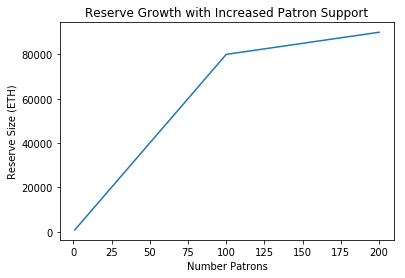

In [11]:
import matplotlib.pyplot as plt
print(patrons_list)
print(reserve_sizes)
plt.title("Reserve Growth with Increased Patron Support")
plt.xlabel("Number Patrons")
plt.ylabel("Reserve Size (ETH)")
plt.plot(patrons_list, reserve_sizes)

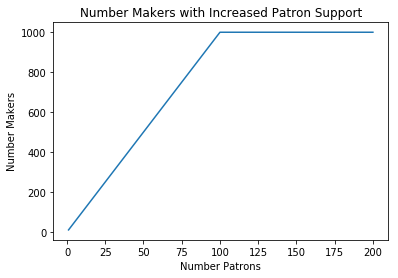

In [12]:
plt.title("Number Makers with Increased Patron Support")
plt.xlabel("Number Patrons")
plt.ylabel("Number Makers")
plt.plot(patrons_list, makers_list)

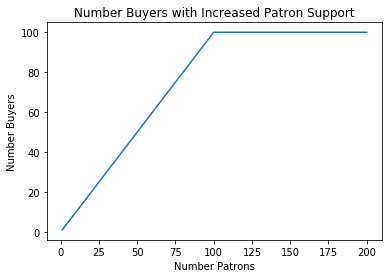

In [13]:
plt.title("Number Buyers with Increased Patron Support")
plt.xlabel("Number Patrons")
plt.ylabel("Number Buyers")
plt.plot(patrons_list, buyers_list)

The shape of the reserve growth curve is interesting. It takes on a piecewise linear shape with the addition of the ceiling on the number of makers and buyers. I suspect that the slow growth at the tail end basically means that the market is saturated out and only the extra patron funds are contributing to the reserve.

This entire simulation is simplistic since we aren't using a sophisticated model of the agents involved. I think that the real reserve growth curve is something more like a sigmoidal function

$y = 80000 * \text{sigmoid}(x) - 40000$

So there's a linear growth phase followed by a plateau after